---
title: "upsampling"
execute:
  freeze: auto  # re-render only when source changes
---

In the previous chapter, we resampled from fine temporal resolution to a coarser one. This is also called **downsampling**. We will learn the **upsampling** now: how to go from coarse data to a finer scale.

Sadly, there is no free lunch, and we just can't get data that was not measured. What to do then?

It's best to consider a practical example.

## Potential Evapotranspiration using Penman's equation

We want to calculate the daily potential evapotranspiration using [Penman's equation](http://yairmau.com/surface-hydrology/evapotranspiration/evapotranspiration-lecture.html#net-radiation). Part of the calculation involves characterizing the energy budget on soil surface. When direct solar radiation measurements are not available, we can estimate the energy balance by knowing the "cloudless skies mean solar radiation", $R_{so}$. This is the amount of energy (MJ/m$^2$/d) that hits the surface, assuming no clouds. This radiation depends on the season and on the latitude you are. For Israel, located at latitude 32° N, we can use the following data for 30°:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters

In [2]:
dates = pd.date_range(start='2021-01-01', periods=13, freq='MS')
values = [17.46, 21.65, 25.96, 29.85, 32.11, 33.20, 32.66, 30.44, 26.67, 22.48, 18.30, 16.04, 17.46]
df = pd.DataFrame({'date': dates, 'radiation': values})
df = df.set_index('date')
df

,radiation
date,
2021-01-01,17.46
2021-02-01,21.65
2021-03-01,25.96
2021-04-01,29.85
2021-05-01,32.11
2021-06-01,33.20
2021-07-01,32.66
2021-08-01,30.44
2021-09-01,26.67


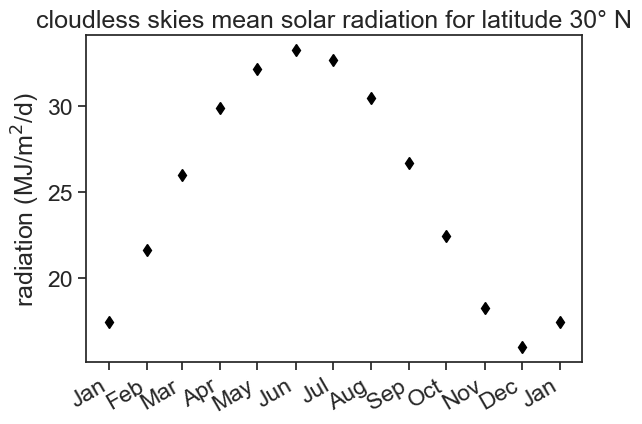

In [3]:
fig, ax = plt.subplots()
ax.plot(df['radiation'], color='black', marker='d', linestyle='None')
ax.set(ylabel=r'radiation (MJ/m$^2$/d)',
       title="cloudless skies mean solar radiation for latitude 30° N")
ax.xaxis.set_major_locator(mdates.MonthLocator())
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
plt.gcf().autofmt_xdate()  # makes slanted dates

We only have 12 values for the whole year, and we can't use this dataframe to compute daily ET. We need to upsample!

In the example below, we resample the monthly data into daily data, and do nothing else. Pandas doesn't know what to do with the new points, so it fills them with NaN.

In [27]:
df_nan = df.asfreq('D')
df_nan.head(33)

,radiation
date,
2021-01-01,17.46
2021-01-02,NaN
2021-01-03,NaN
2021-01-04,NaN
2021-01-05,NaN
2021-01-06,NaN
2021-01-07,NaN
2021-01-08,NaN
2021-01-09,NaN


## Forward/Backward fill

We can forward/backward fill these NaNs:

In [21]:
df_forw = df_nan.ffill()
df_back = df_nan.bfill()

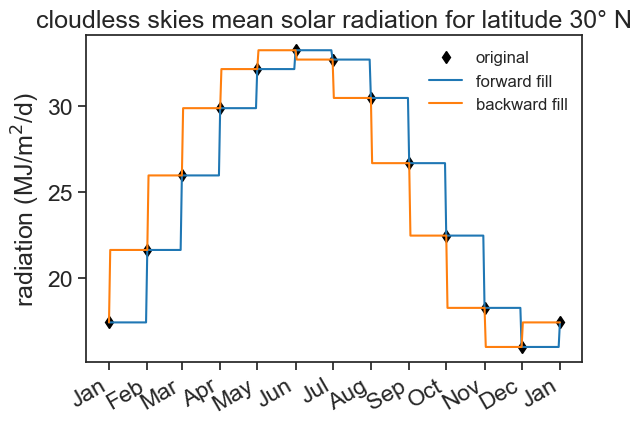

In [22]:
fig, ax = plt.subplots()
ax.plot(df['radiation'], color='black', marker='d', linestyle='None', label="original")
ax.plot(df_forw['radiation'], color='tab:blue', label="forward fill")
ax.plot(df_back['radiation'], color='tab:orange', label="backward fill")
ax.set(ylabel=r'radiation (MJ/m$^2$/d)',
       title="cloudless skies mean solar radiation for latitude 30° N")
ax.legend(frameon=False, fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator())
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
plt.gcf().autofmt_xdate()  # makes slanted dates

We first used `asfreq`, and the filled the NaN values with something. Instead of doing this in two steps, we can do the following:

In [31]:
df.resample('D').interpolate(method='ffill')

/var/folders/cn/m58l7p_j6j10_4c43j4pd8gw0000gq/T/ipykernel_60150/897677981.py:1: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.resample('D').interpolate(method='ffill')


,radiation
date,
2021-01-01,17.46
2021-01-02,17.46
2021-01-03,17.46
2021-01-04,17.46
2021-01-05,17.46
...,...
2021-12-28,16.04
2021-12-29,16.04
2021-12-30,16.04





This does the job, but I want something better, not step functions. The radiation should vary smoothly from day to day. Let's use other kinds of interpolation.

## Interpolation

In [23]:
df_linear = df['radiation'].resample('D').interpolate(method='time').to_frame()
df_cubic = df['radiation'].resample('D').interpolate(method='cubic').to_frame()

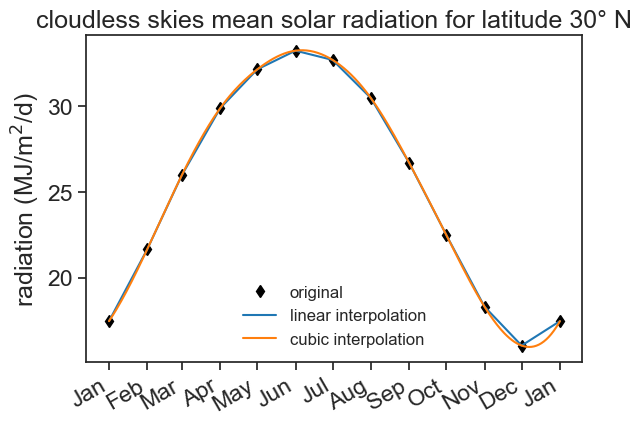

In [8]:
fig, ax = plt.subplots()
ax.plot(df['radiation'], color='black', marker='d', linestyle='None', label="original")
ax.plot(df_linear['radiation'], color='tab:blue', label="linear interpolation")
ax.plot(df_cubic['radiation'], color='tab:orange', label="cubic interpolation")
ax.set(ylabel=r'radiation (MJ/m$^2$/d)',
       title="cloudless skies mean solar radiation for latitude 30° N")
ax.legend(frameon=False, fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator())
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
plt.gcf().autofmt_xdate()  # makes slanted dates

There are many ways to fill NaNs and to interpolate. A nice detailed guide can be [found here](https://note.nkmk.me/en/python-pandas-interpolate/).

## Dealing with missing rows

There is a difference between missing rows and NaN values. The first is when we have a gap in the index, and the second is when we have a value that is missing.

Now we will produce two derivative datasets, one where the month of August is full of NaN values, the other where all the rows of the month of August are removed.

In [33]:
df_missing = df_cubic[~df_cubic.index.month.isin([8])]
df_nan = df_cubic.copy()
df_cubic.loc[df_cubic.index.month.isin([8])] = np.nan
# see the difference between the two dataframes
print(df_missing['2021-07-29':])
print(df_nan['2021-07-29':])

            radiation
date                 
2021-07-29  30.731457
2021-07-30  30.636204
2021-07-31  30.539054
2021-09-01  26.670000
2021-09-02  26.534642
...               ...
2021-12-28  16.995662
2021-12-29  17.103029
2021-12-30  17.216164
2021-12-31  17.335133
2022-01-01  17.460000

[126 rows x 1 columns]
            radiation
date                 
2021-07-29  30.731457
2021-07-30  30.636204
2021-07-31  30.539054
2021-08-01        NaN
2021-08-02        NaN
...               ...
2021-12-28  16.995662
2021-12-29  17.103029
2021-12-30  17.216164
2021-12-31  17.335133
2022-01-01  17.460000

[157 rows x 1 columns]


When plotting the data, we see that missing rows don't produce gaps in the lineplot. Depending on the data, we would never know this just by looking at the plot!

Text(0, 0.5, 'NaNs')

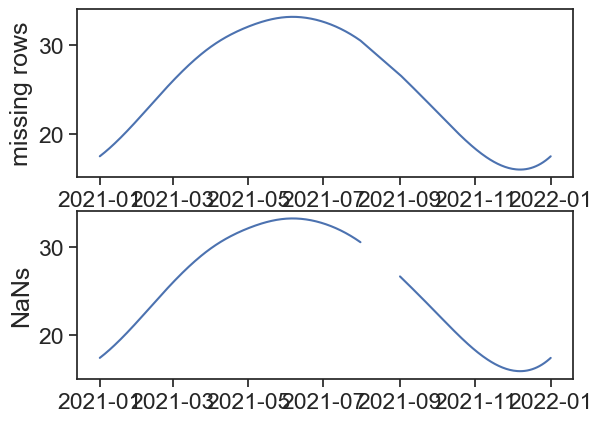

In [35]:
fig, ax = plt.subplots(2,1)
ax[0].plot(df_missing)
ax[0].set_ylabel("missing rows")
ax[1].plot(df_nan)
ax[1].set_ylabel("NaNs")

Use the `asfreq` method to fill the missing rows with NaNs.

Text(0, 0.5, 'NaNs')

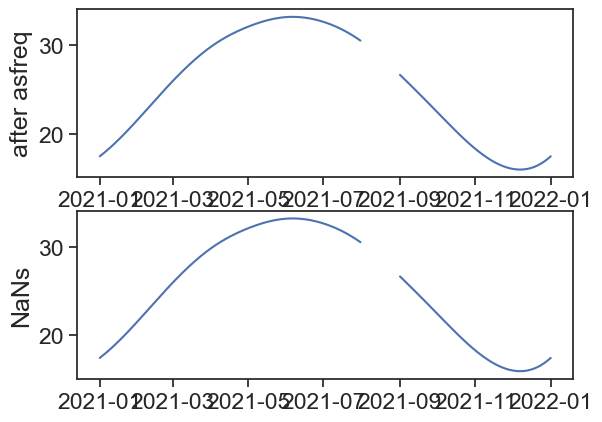

In [36]:
df_asfreq = df_missing.asfreq('D')
fig, ax = plt.subplots(2,1)
ax[0].plot(df_asfreq)
ax[0].set_ylabel("after asfreq")
ax[1].plot(df_nan)
ax[1].set_ylabel("NaNs")